In [14]:
import numpy as np
import pandas as pd
import xarray as xr
import math as mt
from joblib import dump, load

import datetime

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from sklearn.model_selection import train_test_split
from random import seed
from random import randint
import statistics
from scipy.stats import stats
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from time import time
from math import e


In [3]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')

#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
y=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2018-12-31'))
y=y/25.0

In [5]:
#Surface data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')
# 850 Data
tuv850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_uvt_daily_NovDecJan.nc')
z850Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_850_z_daily_NovDecJan.nc')
#700 Data
w700Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_700_w_daily_NovDecJan.nc')
# Read Orography
OroData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5IGP_Orography.nc')

In [6]:
t2mD = t2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
u10D = u10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
v10D = v10Data.sel(latitude=slice(32,24),longitude=slice(74,86))
d2mD = d2mData.sel(latitude=slice(32,24),longitude=slice(74,86))
tuv850D = tuv850Data.sel(latitude=slice(32,24),longitude=slice(74,86))
z850D = z850Data.sel(latitude=slice(32,24),longitude=slice(74,86))
w700D = w700Data.sel(latitude=slice(32,24),longitude=slice(74,86))
OroD = OroData.sel(latitude=slice(32,24),longitude=slice(74,86))

In [15]:
# Calculate wind speed and relative humidity
ws = ((v10D.v10.values**2)+(u10D.u10.values**2))**0.5
ws_ds = xr.Dataset({'ws': (('time','latitude','longitude'), ws)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
rh = (e**((17.625*(d2mD.d2m.values-273.15))/(243.04+(d2mD.d2m.values-273.15)))/e**((17.625*(t2mD.t2m.values-273.15))/(243.04+(t2mD.t2m.values-273.15))))
rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
#Calculate inv
inv=t2mD.t2m.values-tuv850D.t.values
inv_ds = xr.Dataset({'inv': (('time','latitude','longitude'), inv)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
inv_ds.attrs
inv_ds.attrs['units']='K'
inv_ds.attrs['long_name']='t2m - t850'

In [16]:
#u shear calculation
ushear=(tuv850D.u.values-u10D.u10.values)/(z850D.z.values/9.81) 
ushear_ds = xr.Dataset({'ushear': (('time','latitude','longitude'), ushear)}, coords={'time': v10D.time,'latitude': v10D.latitude,'longitude': v10D.longitude})
ushear_ds.attrs['units']='s-1'
ushear_ds.attrs['long_name']='(u10 - u850)/z850'

In [17]:
# create mask
oro = OroD.z
oro.values = OroD.z.values/9.81
oro.attrs
oro.attrs['units']='meter'
oro.attrs['long_name']='Orography'
oro.values[oro.values>500.1]=np.NaN
mask=oro.values/oro.values
# Chk mask
#t2mD.t2m.values=t2mD.t2m.values*mask
#t2mD.t2m[0,:,:].plot(cmap='jet')

In [18]:
# Apply Mask 
t2mD.t2m.values=t2mD.t2m.values*mask
ws_ds.ws.values=ws_ds.ws.values*mask
rh_ds.rh.values=rh_ds.rh.values*mask
w700D.w.values=w700D.w.values*mask
inv_ds.inv.values=inv_ds.inv.values*mask
ushear_ds.ushear.values=ushear_ds.ushear.values*mask

In [19]:
# Feild mean
t2mTS1=t2mD.mean(dim=['latitude','longitude'], skipna=True).t2m
wsTS1=ws_ds.mean(dim=['latitude','longitude'], skipna=True).ws
rhTS1=rh_ds.mean(dim=['latitude','longitude'], skipna=True).rh
wTS1=w700D.mean(dim=['latitude','longitude'], skipna=True).w
invTS1=inv_ds.mean(dim=['latitude','longitude'], skipna=True).inv
ushearTS1=ushear_ds.mean(dim=['latitude','longitude'], skipna=True).ushear

In [20]:
# shift one day so we can take values of previous day
t2mTS=t2mTS1.shift(time=1)
wsTS=wsTS1.shift(time=1)
rhTS=rhTS1.shift(time=1)
wTS=wTS1.shift(time=1)
invTS=invTS1.shift(time=1)
ushearTS=ushearTS1.shift(time=1)

In [21]:
# Select required time 
t2m=t2mTS[((t2mTS.time.dt.month>11) | (t2mTS.time.dt.month<2)) & (t2mTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'))
ws=wsTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'))
inv=invTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'))
rh=rhTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'))
w=wTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'))
ushear=ushearTS[((wsTS.time.dt.month>11) | (wsTS.time.dt.month<2)) & (wsTS.time.dt.year<2020)].sel(time=slice('1980-1-1','2018-12-31'))

In [22]:
# input X
X       = pd.DataFrame([t2m.values,ws.values,rh.values,inv.values,w.values,ushear.values*100.0]).T[:]
#X       = pd.DataFrame([ws.values,rh.values,inv.values,w.values]).T[:]
X.index = pd.to_datetime(t2m.time.values)
X

,0,1,2,3,4,5
1980-01-01 09:00:00,289.120636,1.737170,0.681204,5.449228,-0.103194,0.353420
1980-01-02 09:00:00,288.971771,2.071385,0.743338,5.749483,-0.125205,0.273085
1980-01-03 09:00:00,288.303253,1.375861,0.758891,6.781636,-0.049128,0.160400
1980-01-04 09:00:00,287.083527,1.883535,0.746639,6.586329,0.070247,0.053234
1980-01-05 09:00:00,286.249054,1.991354,0.709822,5.626440,0.038802,0.038249
...,...,...,...,...,...,...
2018-12-27 09:00:00,287.116974,1.433200,0.588758,4.247632,-0.025993,0.314777
2018-12-28 09:00:00,287.040436,1.897564,0.547522,5.767006,0.163933,0.249560
2018-12-29 09:00:00,286.180817,2.137837,0.552296,4.413174,0.137729,0.143824
2018-12-30 09:00:00,286.110046,1.636086,0.564291,1.974165,0.078003,0.081137


In [23]:
norm = StandardScaler().fit(X)
    # transform training data
X = pd.DataFrame(norm.transform(X))
X.index = pd.to_datetime(t2m.time.values)
X

,0,1,2,3,4,5
1980-01-01 09:00:00,0.069270,0.145201,0.579576,0.856872,-2.178138,1.754678
1980-01-02 09:00:00,-0.008947,1.028973,1.367958,1.024354,-2.510069,1.000578
1980-01-03 09:00:00,-0.360198,-0.810212,1.565310,1.600091,-1.362824,-0.057176
1980-01-04 09:00:00,-1.001064,0.532239,1.409848,1.491148,0.437363,-1.063134
1980-01-05 09:00:00,-1.439511,0.817345,0.942694,0.955721,-0.036824,-1.203800
...,...,...,...,...,...,...
2018-12-27 09:00:00,-0.983490,-0.658592,-0.593436,0.186620,-1.013936,1.391936
2018-12-28 09:00:00,-1.023705,0.569334,-1.116653,1.034129,1.850152,0.779749
2018-12-29 09:00:00,-1.475364,1.204693,-1.056081,0.278960,1.454996,-0.212779
2018-12-30 09:00:00,-1.512548,-0.122095,-0.903881,-1.081522,0.554328,-0.801216


In [24]:
regressor = SVR(C= 1, gamma='scale', kernel= 'rbf')
regressor.fit(X, y)

SVR(C=1)

In [28]:
yLR = regressor.predict(X)

In [29]:
test_corr = np.corrcoef(yLR,y)[0,1]

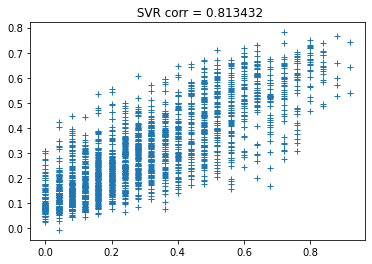

In [30]:
plt.title(' SVR corr = %f'%test_corr)
plt.plot(y,yLR,'+')

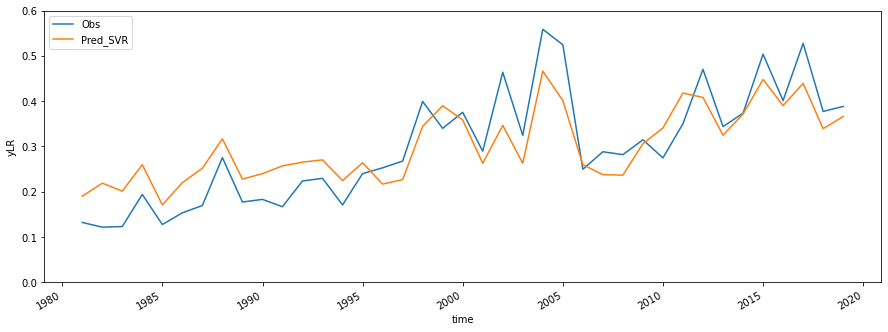

In [31]:
y_predLin_ds=xr.Dataset({'yLR': (('time'), yLR)}, coords={'time': y.time})
dump(y_predLin_ds.yLR,'TS1dataSVR.joblib')
plt.figure(figsize=[15,5])
y.resample(time='1Y').mean().plot(label='Obs')
y_predLin_ds.resample(time='1Y').mean().yLR.plot(label='Pred_SVR')
plt.ylim(0, 0.6)
plt.legend()


In [32]:
ynf=y.where(y==0, drop=True)
ynf

yLRnf=y_predLin_ds.where(y_predLin_ds.yLR<0.04,drop=True)

yWd=y.where(y>0.44, drop=True)
yWd

yLRWd=y_predLin_ds.where(y_predLin_ds.yLR>0.44,drop=True)

yint1=y.where(y>0,drop=True)
yintf=yint1.where(yint1<0.48,drop=True)
yintf

yLRint1=y_predLin_ds.where(y_predLin_ds.yLR>0.039,drop=True)
yLRintf=yLRint1.where(yLRint1<0.48,drop=True)

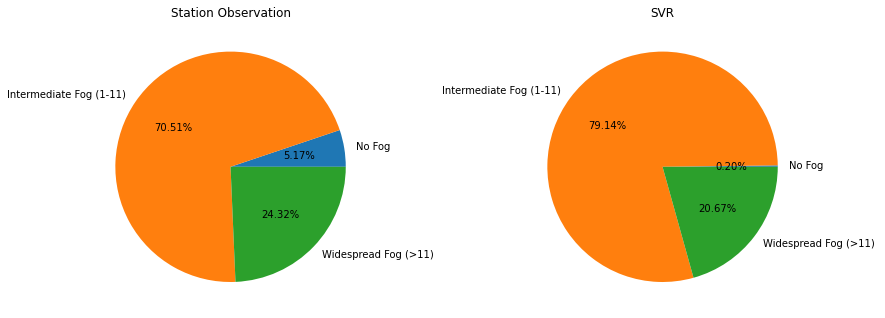

In [33]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [ynf.shape[0],yintf.shape[0],yWd.shape[0]]
ax.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax.set_title('Station Observation')

ax1 = fig.add_axes([1,0,1,1])
ax1.axis('equal')
pieLabs = ['No Fog', 'Intermediate Fog (1-11)', 'Widespread Fog (>11)']
piedata = [yLRnf.yLR.shape[0],yLRintf.yLR.shape[0],yLRWd.yLR.shape[0]]
ax1.pie(piedata, labels = pieLabs,autopct='%1.2f%%')
ax1.set_title('SVR')
plt.show()